(C) 2024, Gerold Baier, University College London

After import of a segment of sEEG, we create a bandpass filtered version.

We will try to interpret the time series in terms of oscillations. This challenges the assumption of an unchanging state of brain activity as modelled by a fixed point equation. 


# The EEG as an Oscillator
## Import and Functions

In [4]:
from numpy import pi, linspace, sin, diff, arange, asarray, ndarray, zeros, exp, array, linspace, median, gradient, around
from numpy import triu, triu_indices, triu_indices_from, var, mean, std, sqrt, where, isnan, nan_to_num, delete, floor
from numpy import nan, flip, argwhere, ones, diag, correlate, corrcoef, transpose, cov, flip, ceil, cos, sin, arctan
from numpy import angle, exp, amax, amin, absolute, meshgrid, fill_diagonal, concatenate, c_, real, argsort, tile
from numpy import empty_like, zeros_like, log, logical_and, copy, greater, invert, nonzero, count_nonzero, divide, repeat
from numpy import sign, append, hstack, savetxt, loadtxt, histogram

from numpy.random import normal, permutation
from numpy.linalg import norm

from matplotlib.pyplot import subplots, xlabel, ylabel, hist, bar, legend, axis
from matplotlib.pyplot import figure, xticks, yticks, rcParams, show

from scipy.optimize import curve_fit
from scipy.signal   import butter, sosfilt, find_peaks
from scipy.stats    import spearmanr, entropy
from scipy.spatial  import distance
from scipy.cluster  import hierarchy
from scipy.interpolate import interp1d
from scipy.fft import rfft, rfftfreq

from pandas import read_csv, DataFrame

import pyedflib

from string import ascii_uppercase

from math import dist


In [5]:
def eeg_plot(data, offset, normalise=True):
    """
    Plot date columns in EEG style
    data:      two-dimensional array
    offset:    scaling factor
    normalise: normalisation of amplitudes to variance 1
    """
    from matplotlib.pyplot import subplots
    
    start = 0
    samples = data.shape[0]
    electrodes = data.shape[1]

    dataset = data[start:start+samples, :electrodes]
    means = data[start:start+samples, :electrodes].mean(axis=0)
    devs = data[start:start+samples, :electrodes].std(axis=0)

    fig, ax = subplots(figsize=(8, 6))

    if not normalise:
        ax.plot((dataset - means)      + offset*arange(electrodes-1,-1,-1), linewidth=1);
    else:
        ax.plot((dataset - means)/devs + offset*arange(electrodes-1,-1,-1), linewidth=1);
    
    ax.plot(zeros((samples, electrodes)) + offset*arange(electrodes-1,-1,-1),'--',color='gray');
    ax.set(ylabel='Voltage')

    yticks([]);
    
    axis('tight');

    return fig, ax


## Pick Patient, Seizure, Type, and read EEG


In [9]:
# read prefiltered 60 sec segment

folder      = '../Data/'
patient     = '1'         # '1'
seizure     = '01'        # '01' or '02' or '03'
series_type = 'Background'     # 'Background' or 'Onset' 

sr_chars = folder + 'sampling_rate.txt'

df1 = read_csv(sr_chars, header=None)

sr = df1.iloc[0, 0]

series_chars = folder + 'Pat' + patient + '_Sz' + seizure + '_' + series_type + '_1_100Hz.csv'

df2 = read_csv(series_chars)
df2.head()

data_np = df2.to_numpy()
data_prefiltered = data_np[:, 1:]

all_labels = df2.columns[1:]

print('')
print(series_chars)
print('')


../Data/Pat1_Sz01_Background_1_100Hz.csv



In [11]:
letter_list = list()

for new in all_labels:
    
    if new[0] not in letter_list:
        
        letter_list.append(new[0])


label_dict = dict()

for ind, letter in enumerate(all_labels):
    
    if letter[0] in label_dict.keys():
            pass

    else:
        label_dict[letter[0]] = [ind]   
        
        dict_ind = len(label_dict.keys())
        
        if letter[0] != all_labels[0][0]:
            previous_letter = letter_list[dict_ind - 2]
            label_dict[previous_letter].append(ind)
            
    if ind == len(all_labels)-1:  
        label_dict[letter[0]].append(ind+1)

label_letters = list(label_dict.keys())

label_dict


{'A': [0, 11],
 'B': [11, 22],
 'C': [22, 31],
 'E': [31, 40],
 'F': [40, 49],
 'Z': [49, 56],
 'O': [56, 67],
 'T': [67, 74],
 'U': [74, 81],
 'V': [81, 92],
 'W': [92, 107],
 'X': [107, 122]}

## Settings and Filtering


In [14]:
data_prefiltered.shape

(60000, 122)

In [16]:
rows_max = data_prefiltered.shape[0]

time_max = rows_max // sr

channel_start, channel_stop = 0, data_prefiltered.shape[1]

number_channels = channel_stop - channel_start

band_low  = 1 # >= 1
band_high = 20

order = 5

sos = butter(order, (band_low, band_high), btype='bandpass', fs=sr, output='sos')

data_filtered = zeros((rows_max, number_channels))

for index, column in enumerate(data_prefiltered.transpose()): 
    forward = sosfilt(sos, column)
    backwards = sosfilt(sos, forward[-1::-1])
    data_filtered[:, index] = backwards[-1::-1]

data_filtered.shape


(60000, 122)

# Complete EEG


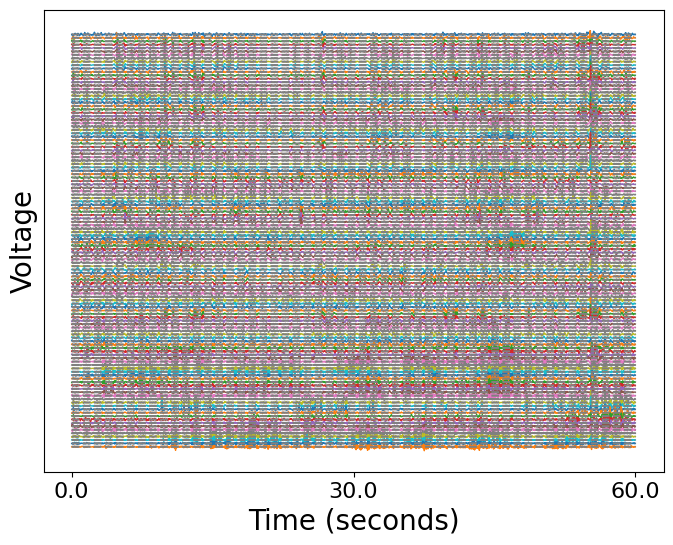

In [19]:
fig, ax = eeg_plot(data_filtered, 5)

ax.set_xticks(linspace(0, rows_max, 3))
labl = linspace(0, time_max, 3)
ax.set_xticklabels(labl, fontsize=16)
ax.set_xlabel('Time (seconds)', fontsize=20)
ax.set_ylabel('Voltage', fontsize=20);


# A Single Electrode


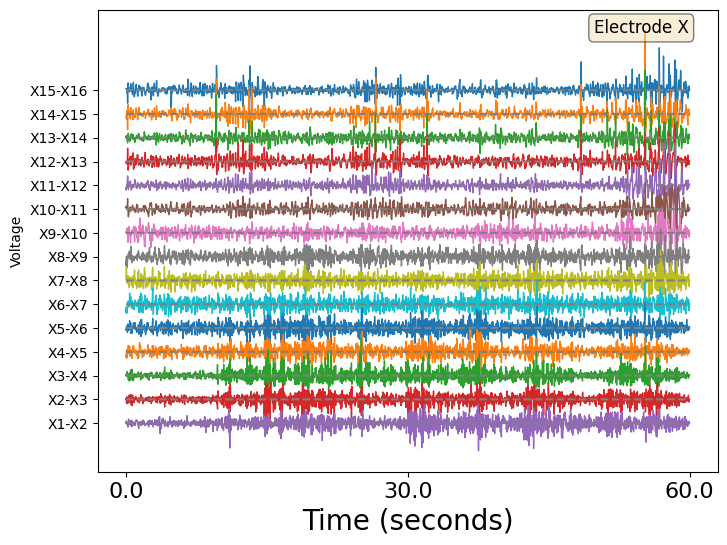

In [22]:
elec_name = 'X'

all_labels_np = asarray(all_labels)

elec_label_names = all_labels_np[label_dict[elec_name][0]:label_dict[elec_name][1]]

data_chan      = data_filtered[:, label_dict[elec_name][0]:label_dict[elec_name][1]]

chans = data_chan.shape[1]

factor = 5

fig, ax = eeg_plot(data_chan, factor, normalise=True)
ax.set_yticks(factor*arange(chans))
ax.set_yticklabels(elec_label_names)

ax.set_xticks(linspace(0, rows_max, 3))
labl = linspace(0, time_max, 3)
ax.set_xticklabels(labl, fontsize=16)
ax.set_xlabel('Time (seconds)', fontsize=20)

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
textstr = 'Electrode ' + elec_name
ax.text(0.80, 0.98, textstr, transform=ax.transAxes, fontsize=12,
    verticalalignment='top', bbox=props);

show()


## Pick a Segment and Normalise

In [25]:
seg_start = 20000
seg_stop  = 30000

rows_seg = seg_stop - seg_start

data_chan_seg      = data_chan[seg_start:seg_stop, :]

means              = data_chan_seg.mean(axis=0)
devs               = data_chan_seg.std(axis=0)
data_chan_seg_norm = (data_chan_seg - means)/devs


## Time Series & Heatmap

figs/Sz01_X_timeseries_L1_H20.png


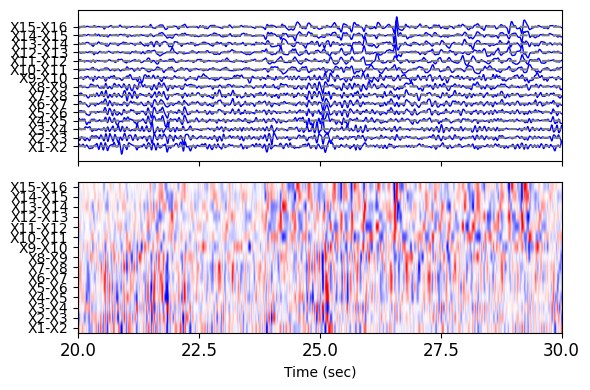

In [28]:
offset = 5

################################### Time Series
fig, (ax1, ax2) = subplots(nrows=2, figsize=(6,4))

### Voltage Series
ax1.plot(data_chan_seg_norm + offset*arange(chans-1,-1,-1), linewidth=1, color='b');
ax1.plot(zeros((rows_seg, chans)) + offset*arange(chans-1,-1,-1),'--',color='gray');
ax1.set_yticks(offset*arange(chans))
ax1.set_yticklabels(elec_label_names)
ax1.margins(x=0)
ax1.set_xticks(linspace(0, rows_seg, 5))
labl =        linspace((seg_start)//sr, (seg_stop)//sr, 5)
ax1.set_xticklabels([], fontsize=12)

### Voltage Heatmap
ax2.imshow(data_chan_seg_norm.T, aspect='auto', cmap='bwr', vmin=-3, vmax=3);
ax2.set_yticks(arange(chans))
ax2.set_yticklabels(flip(elec_label_names));

ax2.set_xticks(linspace(0, rows_seg, 5))
labl =        linspace((seg_start)//sr, (seg_stop)//sr, 5)
ax2.set_xticklabels(labl, fontsize=12)
ax2.set_xlabel('Time (sec)')

fig.tight_layout()

title_chars = 'figs/Sz' + seizure + '_' + elec_name + '_timeseries_' + 'L' + str(band_low) + '_H' + str(band_high) + '.png'
# fig.savefig(title_chars, format='png')
print(title_chars)

show()


## Boxplots of Each Channel

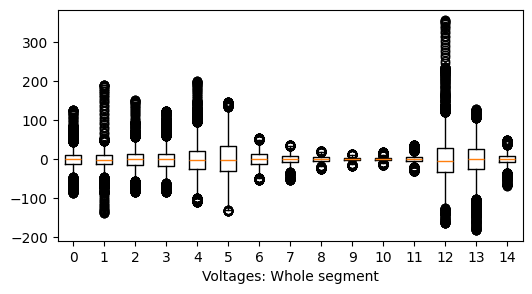

In [31]:
fig, ax = subplots(figsize=(6,3))

ax.boxplot(data_chan_seg);
ax.set_xlabel('Voltages: Whole segment')
ax.set_xticklabels(arange(chans));

show()


## Histograms

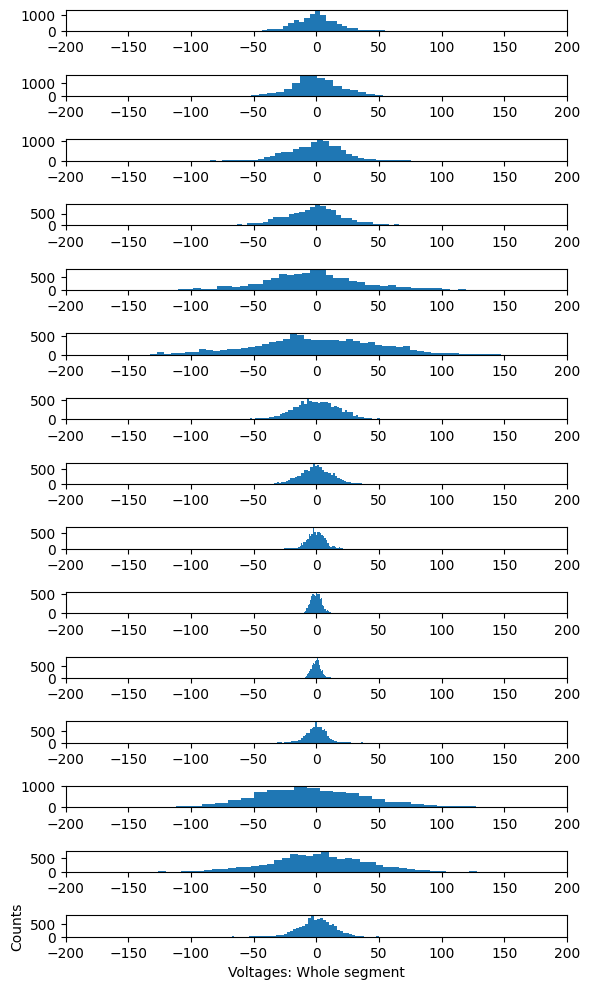

In [34]:
fig, ax = subplots(nrows=chans, figsize=(6,10))

bins = 50

for index in arange(chans):
    
    ax[index].hist(data_chan_seg[:,index], bins=bins);
    ax[index].set_xlim(-200, 200)
    
ax[-1].set_xlabel('Voltages: Whole segment')
ax[-1].set_ylabel('Counts');

fig.tight_layout()

show()


## The Fourier Spectrum

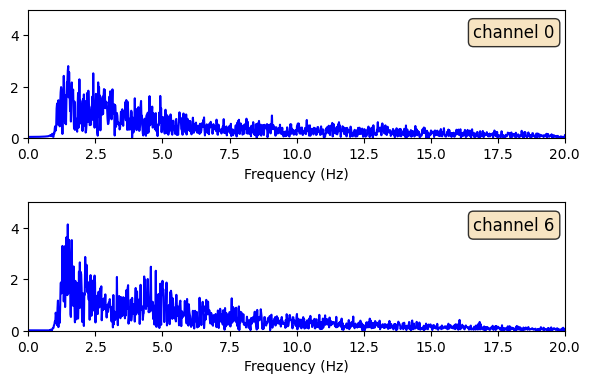

In [37]:
chan1, chan2 = 0, 6

xlim = 20
ylim = 5

# frequencies
freqs = rfftfreq(rows_max, 1 / sr)

# amplitude
amplitudes = (2.0 / rows_max)*abs(rfft(data_filtered, axis=0))


fig, ax = subplots(nrows=2, figsize=(6, 4))

ax[0].plot(freqs, amplitudes[:, chan1], color='b');
ax[0].set_xlim(0, xlim);
ax[0].set_ylim(0, ylim);
ax[0].set_xlabel('Frequency (Hz)');

ax[1].plot(freqs, amplitudes[:, chan2], color='b');
ax[1].set_xlim(0, xlim);
ax[1].set_ylim(0, ylim);
ax[1].set_xlabel('Frequency (Hz)');

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)

# place a text box in upper left in axes coords
textstr = 'channel ' + str(chan1)

ax[0].text(0.83, 0.89, textstr, transform=ax[0].transAxes, fontsize=12,
    verticalalignment='top', bbox=props)

textstr = 'channel ' + str(chan2)

ax[1].text(0.83, 0.89, textstr, transform=ax[1].transAxes, fontsize=12,
    verticalalignment='top', bbox=props)

fig.tight_layout()

show()


## Boxplots & Histograms of Half Segments

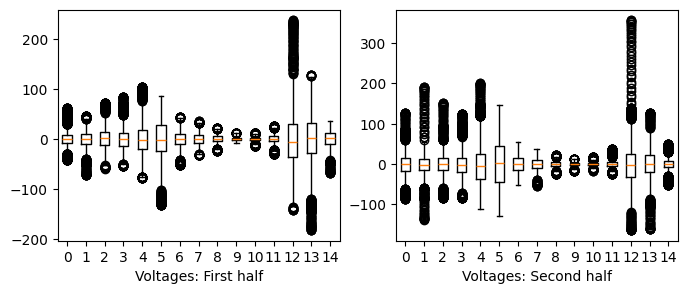

In [41]:
fig, ax = subplots(ncols=2, figsize=(8,3))

ax[0].boxplot(data_chan_seg[:rows_seg//2,:]);
ax[0].set_xticklabels(arange(chans))

ax[0].set_xlabel('Voltages: First half')

ax[1].boxplot(data_chan_seg[rows_seg//2:,:]);
ax[1].set_xticklabels(arange(chans))

ax[1].set_xlabel('Voltages: Second half');

show()


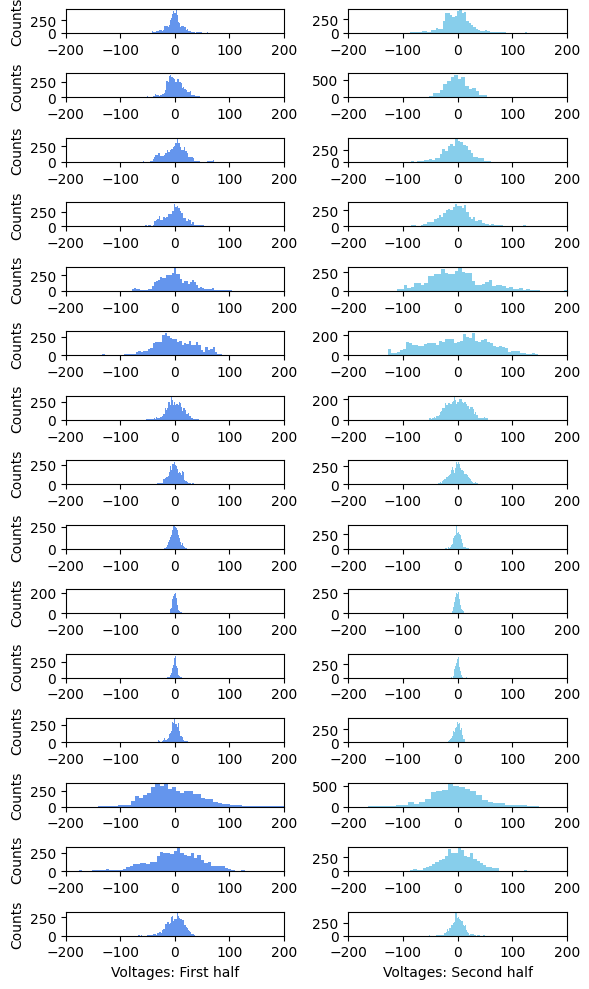

In [43]:
fig, ax = subplots(nrows=chans, ncols=2, figsize=(6,10))

limit = 200

for index in arange(chans):
    
    ax[index, 0].hist(data_chan_seg[:rows_seg//2,index], bins=bins, color='cornflowerblue');
    ax[index, 0].set_ylabel('Counts');
    ax[index, 1].hist(data_chan_seg[rows_seg//2:,index], bins=bins, color='skyblue');
    ax[index, 0].set_xlim(-limit, limit)
    ax[index, 1].set_xlim(-limit, limit)

ax[-1, 0].set_xlabel('Voltages: First half')
ax[-1, 1].set_xlabel('Voltages: Second half')

fig.tight_layout()

show()


## Fourier spectra of half segments

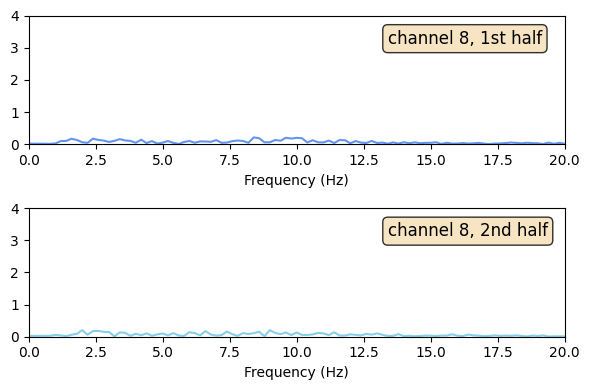

In [46]:
chan = 8

xlim = 20
ylim = 4

# frequencies
freqs = rfftfreq(rows_seg//2, 1 / sr)

# amplitude
amplitudes_1 = (2.0 / rows_max)*abs(rfft(data_chan_seg[:rows_seg//2, :], axis=0))
amplitudes_2 = (2.0 / rows_max)*abs(rfft(data_chan_seg[rows_seg//2:, :], axis=0))


fig, ax = subplots(nrows=2, figsize=(6, 4))

ax[0].plot(freqs, amplitudes_1[:, chan], color='cornflowerblue');
ax[0].set_xlim(0, xlim);
ax[0].set_ylim(0, ylim);
ax[0].set_xlabel('Frequency (Hz)');

ax[1].plot(freqs, amplitudes_2[:, chan], color='skyblue');
ax[1].set_xlim(0, xlim);
ax[1].set_ylim(0, ylim);
ax[1].set_xlabel('Frequency (Hz)');

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)

# place a text box in upper left in axes coords
textstr = 'channel ' + str(chan) + ', 1st half'

ax[0].text(0.67, 0.89, textstr, transform=ax[0].transAxes, fontsize=12,
    verticalalignment='top', bbox=props)

textstr = 'channel ' + str(chan) + ', 2nd half'

ax[1].text(0.67, 0.89, textstr, transform=ax[1].transAxes, fontsize=12,
    verticalalignment='top', bbox=props)

fig.tight_layout()

show()


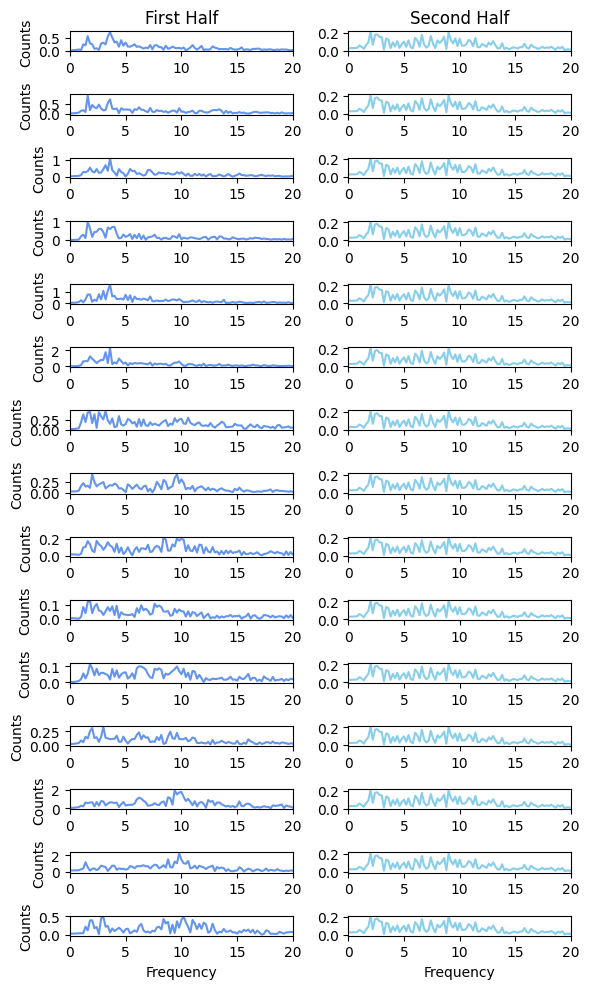

In [48]:
fig, ax = subplots(nrows=chans, ncols=2, figsize=(6,10))

for index in arange(chans):
    
    ax[index, 0].plot(freqs, amplitudes_1[:, index], color='cornflowerblue');
    ax[index, 0].set_ylabel('Counts');
    ax[index, 1].plot(freqs, amplitudes_2[:, chan], color='skyblue');
    ax[index, 0].set_xlim(0, xlim)
    ax[index, 1].set_xlim(0, xlim)

    if index == 0:

        ax[index, 0].set_title('First Half')
        ax[index, 1].set_title('Second Half')

ax[-1, 0].set_xlabel('Frequency')
ax[-1, 1].set_xlabel('Frequency')

fig.tight_layout()

show()


All of sEEG is irregular. Changes do not seem to be specific. No particular frequency components are found. Often slow components have higher power than fast components.


# Try It Yourself

> Display data from different electrodes and in different segments. Describe what you see.

> In a clone of the notebook, import data from another segment of EEG from the same patient, e.g. by setting: seizure = '02'. Run the analysis and compare the outputs for the two data sets. Do the boxplots looks similar? Is the frequency content of channels with the same name similar?

